In [1]:
# importing stuff
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

X = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Xp.csv", sep=';')
Y = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Y.csv", sep=';')
M = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_M.csv", sep=';', na_values ='missing')


# For Y

In [2]:
print("\nColumn names:")
print(Y.columns)
# Print number of columns
print(f"\nNumber of columns: {Y.shape[1]}")
print(f"\nNumber of rows: {Y.shape[0]}")


Column names:
Index(['adf', 'adl', 'cf', 'cp', 'dmdcell', 'ndf'], dtype='object')

Number of columns: 6

Number of rows: 1608


In [5]:
# Generate frequency table for each column in M
frequency_table = M.apply(pd.Series.value_counts).fillna(0).astype(int)

# Print the frequency table
print(frequency_table)

      adf  adl   cf   cp  dmdcell  ndf
cal   861  800  500  880      820  860
test  382  356  222  391      365  382
val   287  267  166  293      274  287


In [6]:
from ydata_profiling import ProfileReport
import ipywidgets

profile = ProfileReport(Y, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

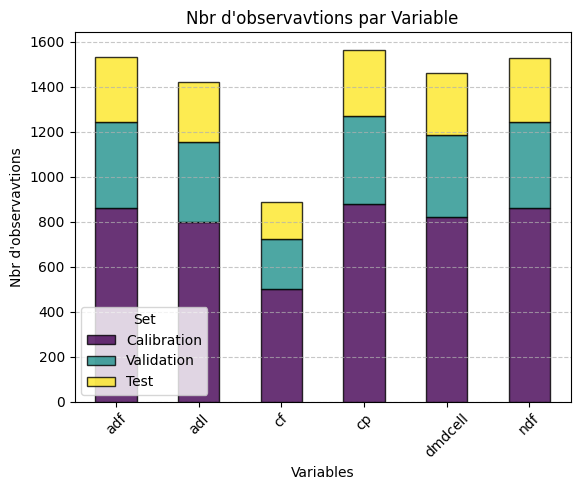

In [ ]:
# Plot bar graph fro the frequencies
counts = M.apply(pd.Series.value_counts).T  # Transpose to get variables as index


plt.figure(figsize=(10, 6))
counts.plot(kind="bar", stacked=True, colormap="viridis", edgecolor="black", alpha=0.8)

plt.xlabel("Variables")
plt.ylabel("Nbr d'observavtions")
plt.title("Nbr d'observavtions par Variable")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Set", labels=["Calibration", "Validation", "Test"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


# For X


# Exploratory data analysis

In [3]:
def split_data(Var):

    if Var not in Y.columns or Var not in M.columns:
        raise ValueError(f"Errer Erreur Erreur ! ! !")

    mask = M[Var]

    # Split X and Y based on M.csv values
    X_cal = X[mask == 'cal']
    Y_cal = Y.loc[X_cal.index, Var]

    X_val = X[mask == 'val']
    Y_val = Y.loc[X_val.index, Var]

    X_test = X[mask == 'test']
    Y_test = Y.loc[X_test.index, Var]

    return (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test)

In [4]:
def perform_pca(X_cal, X_val, X_test, var, C1, C2, C3, ncomp=10):
    # Merge calibration and validation sets to create the training set
    X_train = pd.concat([X_cal, X_val])

    # Apply PCA (3 components for 3D plot)
    pca = PCA(n_components=ncomp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Explained variance per component
    explained_variance = pca.explained_variance_ratio_

    # Create figure with two subplots
    fig = plt.figure(figsize=(12, 5))

    # 3D Scatter Plot for PCA projection
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X_train_pca[:, C1], X_train_pca[:, C2], X_train_pca[:, C3], 
                alpha=0.5, color='blue', label="Training (Cal + Val)")
    ax1.scatter(X_test_pca[:, C1], X_test_pca[:, C2], X_test_pca[:, C3], 
                alpha=0.6, color='red', label="Test")
    ax1.set_xlabel(f"PC {C1}")
    ax1.set_ylabel(f"PC {C2}")
    ax1.set_zlabel(f"PC {C3}")
    ax1.set_title("Projection PCA en 3D (variable = {})".format(var))
    ax1.legend()
    ax1.grid(True)

    # Explained Variance Plot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(1, len(explained_variance) + 1), explained_variance, 
             color='black', alpha=0.7, marker='o')
    ax2.set_xlabel("Nbr de Composantes Principales")
    ax2.set_ylabel("Variance Expliquée")
    ax2.set_title("Variance Expliquée par Composante")
    ax2.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

In [5]:
def plot_histogram(Y_cal, Y_val, Y_test, var):

    Y_train = pd.concat([Y_cal, Y_val])

    mean_train = Y_train.mean()
    mean_test = Y_test.mean()

    plt.figure(figsize=(10, 6))
    
    # Plot histograms with KDE
    sns.histplot(Y_train, color='blue', alpha=0.7, 
                 label="Training (Cal + Val)", kde=True, bins=30)
    sns.histplot(Y_test, color='red', alpha=0.5, 
                 label="Test", kde=True, bins=30)

    # Add mean lines
    plt.axvline(mean_train, color='blue', linestyle='dashed', linewidth=1.5, 
                label=f"Mean Train: {mean_train:.2f}")
    plt.axvline(mean_test, color='red', linestyle='dashed', linewidth=1.5, 
                label=f"Mean Test: {mean_test:.2f}")

    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title(f"Distribution of {var} with Normality Test p-values")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [6]:
Var = 'dmdcell'

(X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(Var)
Y_train = pd.concat([Y_cal, Y_val])
X_train = pd.concat([X_cal, X_val])

# Summary statistics
summary_stats = pd.DataFrame({
    "Training (Cal + Val)": Y_train.describe(),
    "Test": Y_test.describe()
})
print("Statistiaues:\n", summary_stats)

Statistiaues:
        Training (Cal + Val)        Test
count           1094.000000  365.000000
mean              53.300420   53.298822
std               16.438469   16.581883
min               10.230000    9.900000
25%               42.537500   42.550000
50%               53.485000   53.490000
75%               65.427500   65.360000
max               94.210000   95.000000


In [16]:
# Print column names
print("\nColumn names:")
print(X.columns)
# Print number of columns
print(f"\nNumber of columns: {X.shape[1]}")
print(f"\nNumber of rows: {X.shape[0]}")



Column names:
Index(['1100', '1102', '1104', '1106', '1108', '1110', '1112', '1114', '1116',
       '1118',
       ...
       '2480', '2482', '2484', '2486', '2488', '2490', '2492', '2494', '2496',
       '2498'],
      dtype='object', length=700)

Number of columns: 700

Number of rows: 1608


In [17]:
# Generate descriptive statistics
print("\nDescriptive analysis:")
print(X.describe())



Descriptive analysis:
              1100         1102         1104         1106         1108  \
count  1608.000000  1608.000000  1608.000000  1608.000000  1608.000000   
mean     -0.000348    -0.000289    -0.000180    -0.000040     0.000098   
std       0.000418     0.000396     0.000328     0.000229     0.000129   
min      -0.003419    -0.003155    -0.002496    -0.001556    -0.000635   
25%      -0.000475    -0.000415    -0.000289    -0.000124     0.000039   
50%      -0.000261    -0.000212    -0.000123    -0.000012     0.000100   
75%      -0.000078    -0.000034     0.000027     0.000103     0.000169   
max       0.000302     0.000393     0.000478     0.000543     0.000571   

              1110         1112         1114         1116         1118  ...  \
count  1608.000000  1608.000000  1608.000000  1608.000000  1608.000000  ...   
mean      0.000191     0.000201     0.000214     0.000236     0.000259  ...   
std       0.000077     0.000087     0.000096     0.000102     0.000104  .

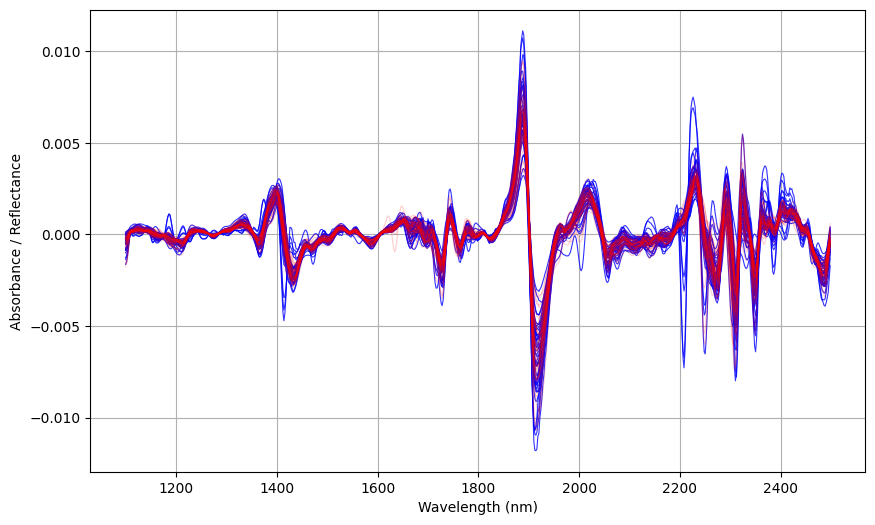

In [18]:
# Plot wavelengths
num_samples = 40
train_samples = X_train.sample(n=min(num_samples, len(X_train)), random_state=42)
test_samples = X_test.sample(n=min(num_samples, len(X_test)), random_state=42)

wavelengths = np.arange(1100, 1100 + X_train.shape[1] * 2, 2)  

# Plot spectral curves
plt.figure(figsize=(10, 6))

for _, row in train_samples.iterrows():
    plt.plot(wavelengths, row, color='blue', alpha=0.8, linewidth=0.8)

for _, row in test_samples.iterrows():
    plt.plot(wavelengths, row, color='red', alpha=0.2, linewidth=0.8)


plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance / Reflectance")
# plt.legend(["Training (Cal + Val)", "Test"])
plt.grid(True)

plt.show()

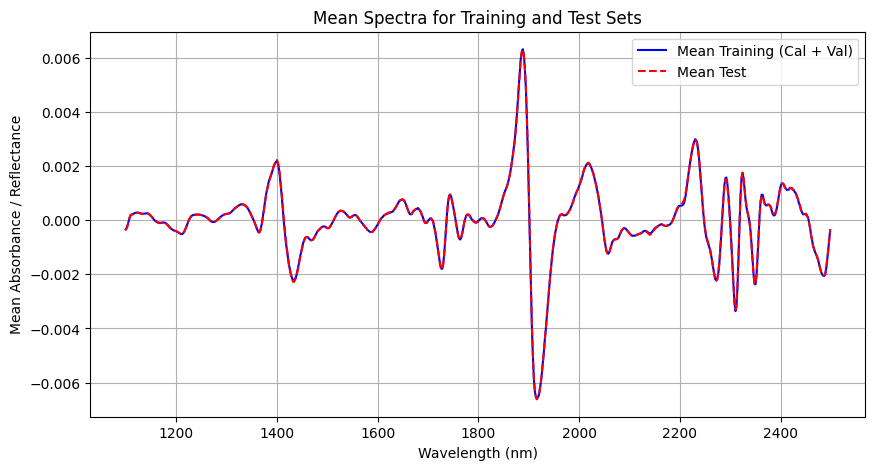

In [19]:
# Moyen pour chaque wavelenght pour comparer
mean_train = X_train.mean(axis=0)
mean_test = X_test.mean(axis=0)

# Generate wavelength values assuming 2nm intervals
wavelengths = np.arange(1100, 1100 + X_train.shape[1] * 2, 2)

# Plot the mean spectra
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, mean_train, label="Mean Training (Cal + Val)", color='blue')
plt.plot(wavelengths, mean_test, label="Mean Test", color='red', linestyle='dashed')

# Labels and styling
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Absorbance / Reflectance")
plt.title("Mean Spectra for Training and Test Sets")
plt.legend()
plt.grid(True)

plt.show()

# ACP

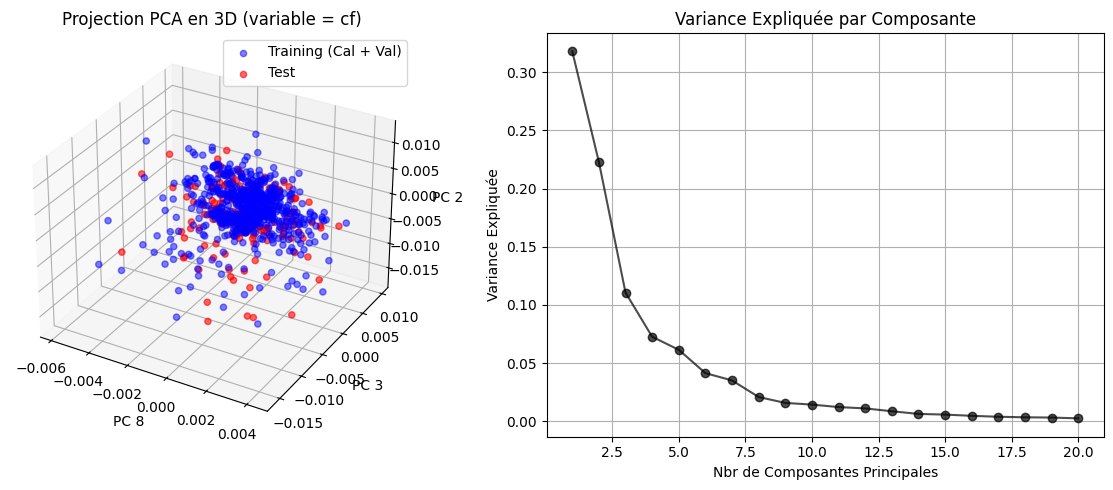

In [93]:
perform_pca(X_cal, X_val, X_test, Var, 8, 3, 2, ncomp=20)

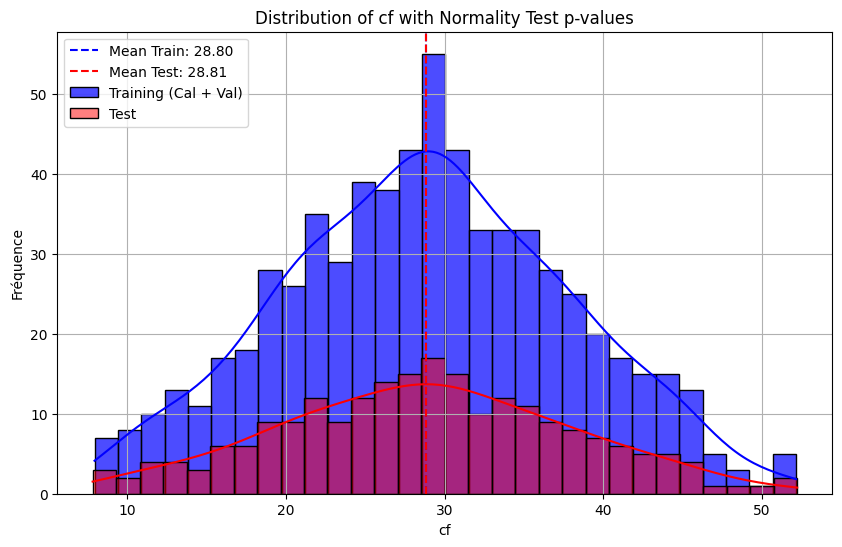

In [94]:
plot_histogram(Y_cal, Y_val, Y_test, Var)

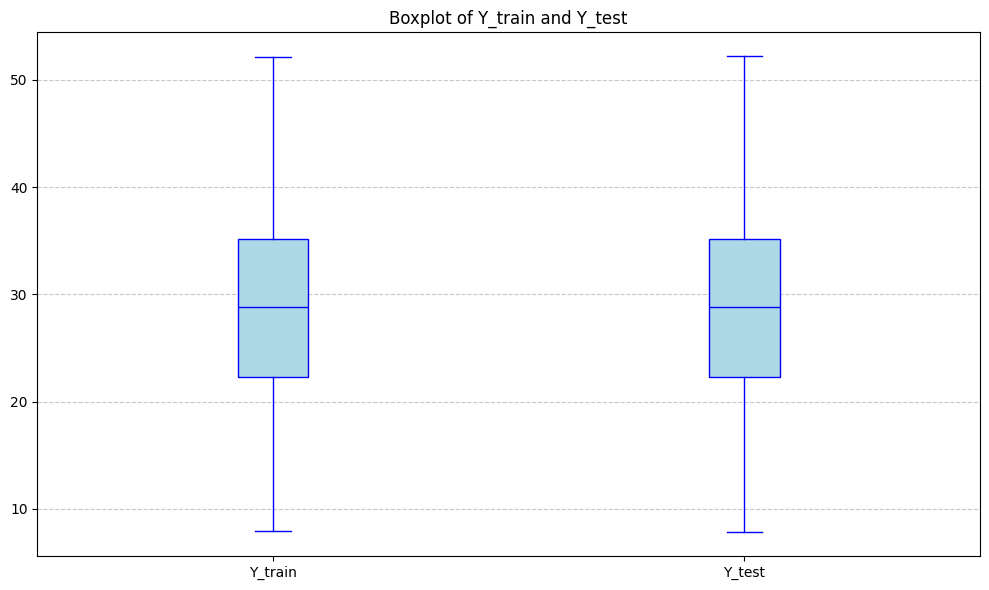

In [66]:
# boxplots
plt.figure(figsize=(10, 6))

plt.boxplot([Y_train, Y_test], labels=['Y_train', 'Y_test'], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'), medianprops=dict(color='blue'), flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

plt.title('Boxplot of Y_train and Y_test')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pairplot pour tt les Vars

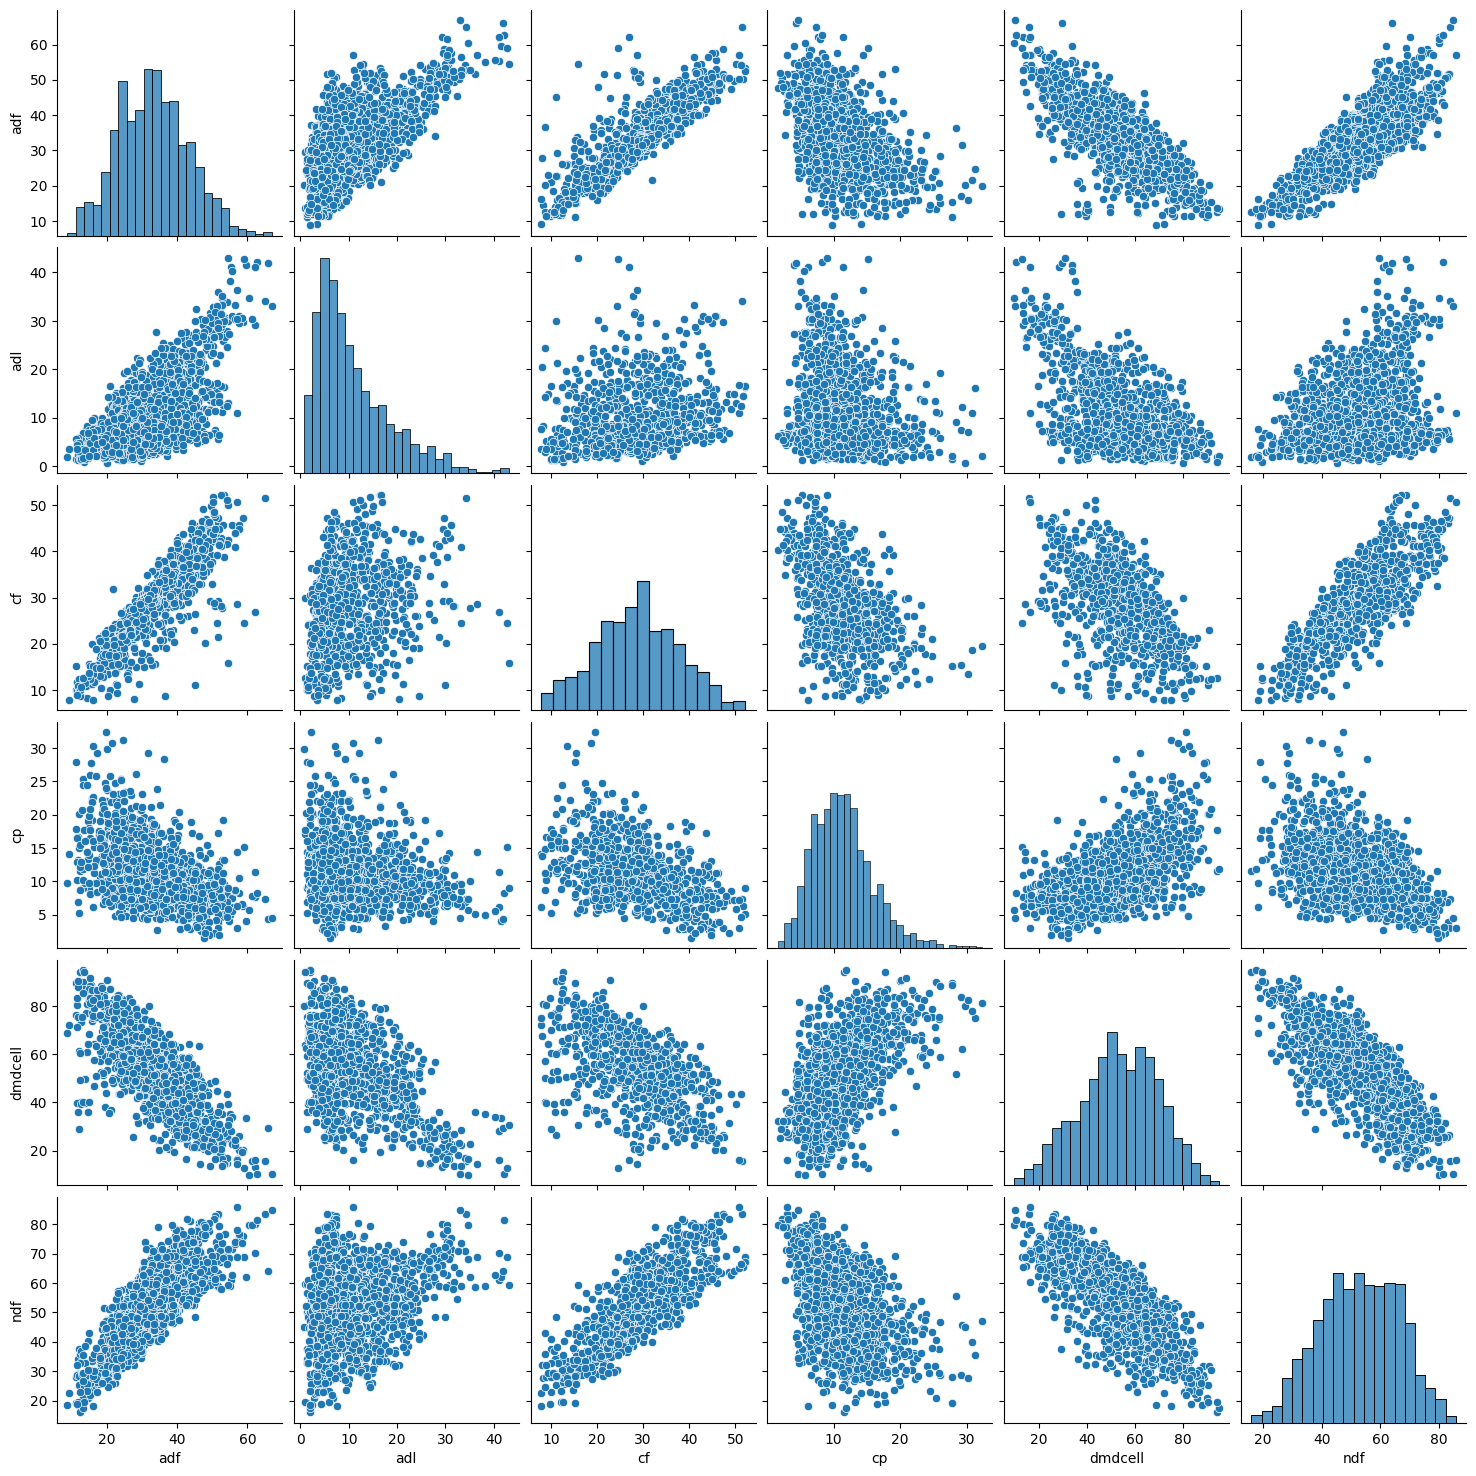

In [145]:
sns.pairplot(Y, diag_kind='hist')

# Show the plot
plt.show()

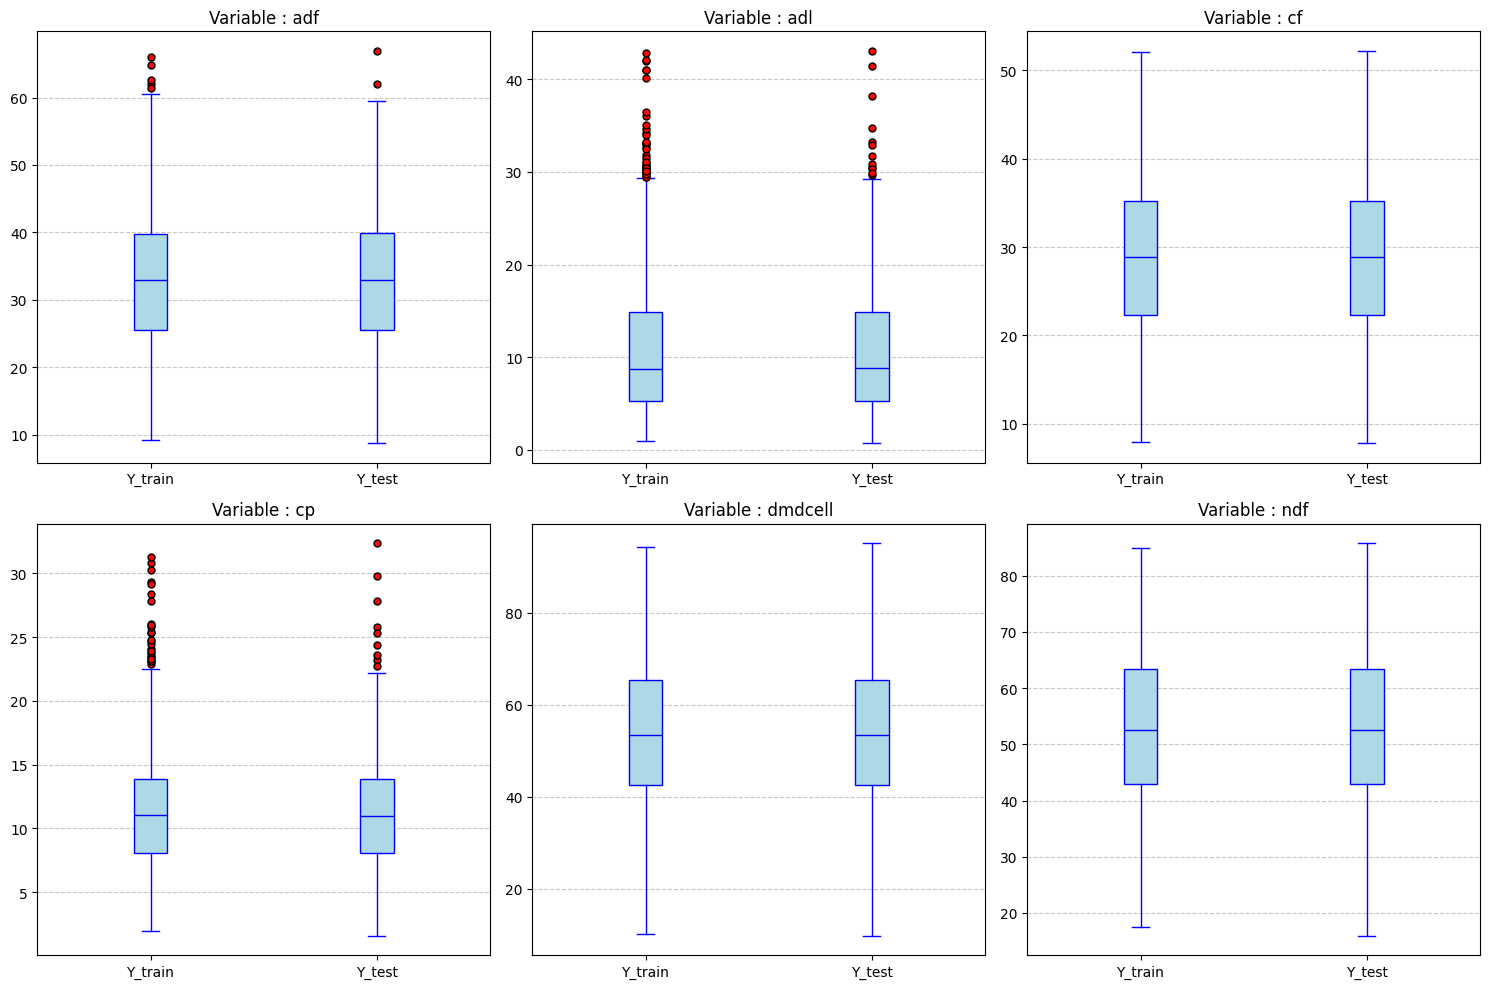

In [ ]:

# List of variables to iterate over
variables = ["adf", "adl", "cf", "cp", "dmdcell", "ndf"]

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Loop through variables and create boxplots
for i, var in enumerate(variables):
    row, col = divmod(i, 3)  # Get subplot row and column index

    # Get the datasets
    (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(var)
    Y_train = pd.concat([Y_cal, Y_val])
    X_train = pd.concat([X_cal, X_val])

    # Create boxplot
    axes[row, col].boxplot([Y_train, Y_test], labels=['Y_train', 'Y_test'],
                           patch_artist=True,
                           boxprops=dict(facecolor='lightblue', color='blue'),
                           whiskerprops=dict(color='blue'),
                           capprops=dict(color='blue'),
                           medianprops=dict(color='blue'),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

    # Titles and formatting
    axes[row, col].set_title(f'Variable : {var}')
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
